<h1>День 5. Оценка упущенной прибыли.</h1>

<h3>Сервисный модуль</h3>
<b><i>Пожалуйста, запустите следующие несколько ячеек при первом запуске ноутбука!</i></b>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pip install -r '/home/jupyter/work/resources/a2nced/requirements.txt'

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 427 kB 1.8 MB/s            
     |████████████████████████████████| 40 kB 9.1 MB/s             
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipystate 0.0.1 requires packaging==20.9, but you have packaging 21.3 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import os
import sys
from pathlib import Path
dir_path = Path(os.getcwd()).resolve().parent.as_posix()
sys.path.append(dir_path)

In [4]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import optuna
from optuna.trial import TrialState

In [5]:
# найдем директорию, в которой хранятся наши данные
_PATH = '/home/jupyter/mnt/s3/course-test/day_5/'

In [6]:
transactions_path = os.path.join(_PATH, 'day_5_transactions.csv') # транзакции
orders_path       = os.path.join(_PATH, 'day_5_orders.csv') # информация о заказах, сгруппированная по корзинам
demographics_path = os.path.join(_PATH, 'day_5_demogr.csv') # информация о клиентах
prod_path         = os.path.join(_PATH, 'day_5_product.csv') # информация о товарах
data_mart_path    = os.path.join(_PATH, 'day_5_datamart.csv') # предварительно собранная витрина

In [7]:
demographics = pd.read_csv(demographics_path)
prod_df = pd.read_csv(prod_path)
transactions_df = pd.read_csv(transactions_path)
transactions_df['purch_date_time'] = transactions_df['purch_date_time'].astype(np.datetime64)
orders_df = pd.read_csv(orders_path)
orders_df['purch_date_time'] = orders_df['purch_date_time'].astype(np.datetime64)

In [8]:
df = demographics[['user_id', 'age_desc', 'income_desc', 'no_kids']] # базовый набор характеристик

In [9]:
available_ids = df['user_id'].values
tr_df = orders_df.loc[orders_df['user_id'].isin(available_ids)]

In [10]:
orders_with_dates = tr_df.groupby(['user_id', 'purch_date_time'])['sales_value'].sum().reset_index()

In [11]:
orders_with_dates.head()

user_id     purch_date_time  sales_value
0        1 2018-09-19 15:56:00        78.66
1        1 2018-10-05 21:02:00        41.10
2        1 2018-10-26 17:04:00        26.90
3        1 2018-11-01 20:37:00        63.43
4        1 2018-11-08 17:03:00        53.45

In [12]:
# загрузим модель отклика, обученную в ходе прошлой практики
import pickle
_FILEPATH = os.path.join(os.path.dirname(os.getcwd()), 'references', 'models', 'day_3_model_response.pkl')

with open(_FILEPATH, 'rb') as pickle_file:
    fitted_model = pickle.load(pickle_file)

In [13]:
# для удобства используем собранную на прошлом занятии витрину
data_mart = pd.read_csv(data_mart_path)
data_mart.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                  11.0   
1        7    45-54      50-74K     True                  13.0   
2        8    25-34      25-34K    False                   1.0   
3       13    25-34      75-99K    False                   2.0   
4       16    45-54      50-74K     True                   3.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  11.0              11.000000                     11.0   
1                  13.0              13.000000                     13.0   
2                9438.0            3156.000000                     29.0   
3               24877.0            8408.428571                     53.0   
4                   7.0               5.000000                      5.0   

   quantity_std_14_days  quantity_sum_14_days  ...  \
0                   NaN                  11.0  ...   
1                   NaN                  13.0  ...   
2           5440.389600                9468.0  ...   
3          10793.009495               58859.0  ...   
4              2.828427                  10.0  ...   

   default_price_median_60_days  default_price_std_60_days  \
0                         21.18                  48.553133   
1                         92.87                  45.756704   
2                         23.32                  44.045991   
3                         37.57                  57.909649   
4                         14.99                   6.330213   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     397.87                            112.27   
1                     454.27                            112.93   
2                     652.16                            167.68   
3                    1350.62                            203.46   
4                      44.79                             12.66   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                               6.67                             103.89   
1                              71.06                             128.37   
2                              19.13                              47.26   
3                              21.62                              59.43   
4                              11.78                              18.11   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                      97.22                        0.765882   
1                                      57.31                       -0.633524   
2                                      28.13                        2.346431   
3                                      37.81                        1.531430   
4                                       6.33                       -0.042649   

   prev_communication  prev_response  
0                   1              1  
1                   1              0  
2                   1              1  
3                   1              1  
4                   1              0  

[5 rows x 138 columns]

In [14]:
scores = fitted_model.predict_proba(data_mart.drop('user_id', axis=1))

In [15]:
# соберем скоры
score_df = pd.DataFrame()
score_df['customer_id'] = data_mart.user_id
score_df['report_date'] = dt.date.today()
score_df['score'] = scores[:,1]

In [16]:
# заберем половну
for_communication = score_df.sort_values('score', ascending=False).iloc[:(scores.shape[0] // 2), 0].values

In [17]:
for_communication

array([2407, 1527, 1337, 1451, 2305, 2351, 2217,  764, 1069, 2007,  982,
        979,  949, 1764, 1944, 1376,  761, 1591, 2370, 2467, 1367, 2243,
       2380, 1653, 2085, 1946, 2162, 2107,  438,  630, 1474, 2307,  864,
       2087, 1775, 2199,  387,  825, 1391, 2378,  732,  540,  866,  997,
        968,  934, 2183, 2322,  400, 1240, 2041, 1179, 2024, 2280,  353,
       1453, 1428, 1299, 1370, 2264,  248,   77, 2020, 1899, 2129,  437,
        426,  548,   13, 1285, 1609, 1146, 1475,  351,  605,  871,  164,
        574, 2200, 1300, 1509, 1517, 1585,  695,  518, 1357,   49, 1462,
        831, 1710,  411,  575, 1529, 1197, 1815, 1015,  469, 2017, 1024,
        235,   98, 1788, 2479, 1848, 1680,  889, 2342, 1795, 2130, 2012,
       1748, 2312, 1708, 2110, 2427,  389,  324,  718, 1694, 1975, 2314,
        314, 1633,   86, 1955,  722, 2190,  418, 2496, 1437, 1012, 2488,
       2116, 1142, 2400,  588, 2448, 2296,  232,  219, 1540,  867, 1804,
        856, 1982,  321,  149,  139,  113, 2489,  3

In [18]:
# загрузим модель и витрину для скоринга

In [19]:
import sklearn
from sklearn.cluster import KMeans
model = KMeans(n_clusters=10, random_state=42)

In [20]:
X = data_mart[data_mart.user_id.isin(for_communication)]

In [21]:
for column in X.select_dtypes(exclude=['Int64', 'float64']).columns.values:
    X[column] = X[column].astype('object')

    
X = X.replace({'<NA>': np.nan})
X = X.replace({True: 1, False: 0})
X = X.replace({pd.NA: np.nan})

In [22]:
categorical_features = X.select_dtypes(exclude=['Int64', 'float64']).columns.values
numeric_features = [feature for feature in list(X.columns) if feature not in categorical_features]

In [23]:
from utils.models import create_pipeline

In [24]:
pipeline = create_pipeline(cat_features=categorical_features,
                           numer_features=numeric_features,
                           model=model)

In [25]:
X['cluster_id'] = pipeline.fit_predict(X)

In [26]:
X[['user_id', 'cluster_id']]

user_id  cluster_id
0          1           8
1          7           8
2          8           2
3         13           0
5         17           4
..       ...         ...
790     2467           9
791     2479           3
794     2488           1
795     2489           9
797     2496           4

[400 rows x 2 columns]

In [27]:
from utils.models import create_stratified_sample
test_df, control_df = create_stratified_sample(X, 'cluster_id', 0.2)

In [28]:
# убедимся, что выборки получились одинаковыми
test_out = test_df.cluster_id.value_counts()
control_out = control_df.cluster_id.value_counts()

In [29]:
samples = test_out.to_frame()
samples.rename({'cluster_id':'test_group'}, axis=1, inplace=True)
samples = samples.merge(control_out, left_index=True, right_index=True)
samples.rename({'cluster_id':'control_group'}, axis=1, inplace=True)


In [30]:
samples.sort_index().head(10)

test_group  control_group
0          12             12
1          11             11
2          12             12
3           3              3
4           3              3
5          17             17
7           3              3
8           9              9

<br>
<h1>Практика 2</h1>
<h3>Анализ результатов пилота</h3>
<br>

In [31]:
import numpy as np

In [32]:
np.random.seed(42)

In [33]:
mu1, sigma1 = 30, 40
mu2, sigma2 = 70, 35

In [34]:
X1 = np.random.normal(mu1, sigma1, 3500)
X2 = np.random.normal(mu2, sigma2, 3500)

In [35]:
result_df = pd.DataFrame({'Контрольная': X1,
                          'Тестовая':X2})
result_df

Контрольная    Тестовая
0       49.868566  111.322432
1       24.469428   48.044029
2       55.907542   71.582795
3       90.921194   71.791927
4       20.633865   52.437553
...           ...         ...
3495   107.406162   59.574662
3496    62.620041   96.916108
3497    28.076460   51.541383
3498    22.673981   69.821268
3499    15.733075   83.956732

[3500 rows x 2 columns]

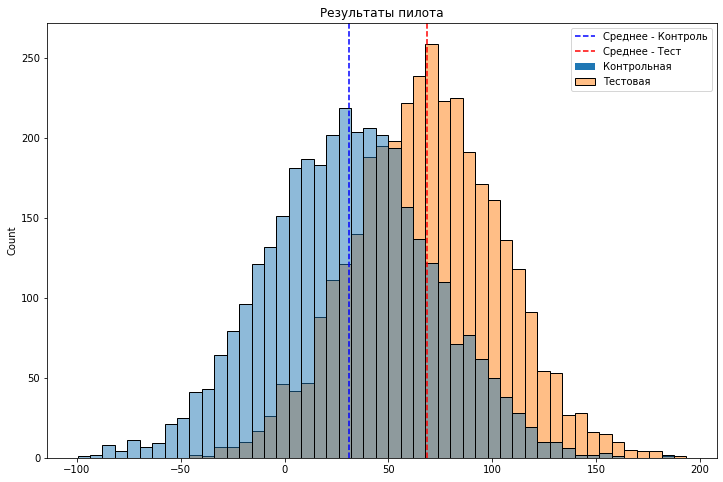

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,8))
sns.histplot(result_df)
plt.axvline(x=X1.mean(),
            color='blue',
            ls='--')
plt.axvline(x=X2.mean(),
            color='red',
            ls='--')
plt.legend([ "Среднее - Контроль", 'Среднее - Тест', 'Контрольная', 'Тестовая'])
plt.title('Результаты пилота')
plt.show()

In [37]:
from scipy.stats import ttest_ind
from mlxtend.evaluate import permutation_test as permutation_test_lib

In [38]:
# t-критерий Стьюдента
ttest_ind(X1, X2)

Ttest_indResult(statistic=-41.898381701749244, pvalue=0.0)

In [39]:
# перестановочный тест
p_value = permutation_test_lib(X1, X2,
                               method='approximate',
                               num_rounds=1000,
                               seed=0)
print(p_value)

0.000999000999000999


In [40]:
# нылевая гипотеза для нас - что выборки взяты из одного распределения
# в первом случае значение p->0 - отвергаем
# во втором - значение далеко выходит за принятые границы уровня значимости (например, 0.05 и 0.01) - наши выборки взяты из одного распредления.

In [41]:
mu3, sigma3 = 50, 20
mu4, sigma4 = 50, 20

In [42]:
X3 = np.random.normal(mu3, sigma3, 350)
X4 = np.random.normal(mu3, sigma3, 350)

In [43]:
result_df_2 = pd.DataFrame({'Контрольная': X3,
                          'Тестовая':X4})
result_df_2

Контрольная   Тестовая
0      65.703702  31.690459
1      14.446381  52.529184
2      64.294913  39.942625
3      45.325519  73.577319
4      64.149154  76.223246
..           ...        ...
345    29.641770  79.112010
346    33.556688  70.633075
347    24.247894  21.821618
348    31.991031  58.897918
349    78.389114  67.014388

[350 rows x 2 columns]

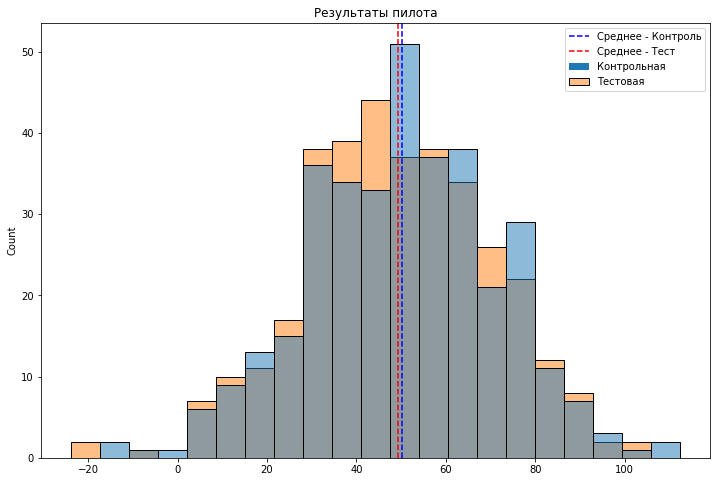

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,8))
sns.histplot(result_df_2)
plt.axvline(x=X3.mean(),
            color='blue',
            ls='--')
plt.axvline(x=X4.mean(),
            color='red',
            ls='--')
plt.legend([ "Среднее - Контроль", 'Среднее - Тест', 'Контрольная', 'Тестовая'])
plt.title('Результаты пилота')
plt.show()

In [45]:
ttest_ind(X3, X4)

Ttest_indResult(statistic=0.554243089384292, pvalue=0.5795900163004394)

In [46]:
# перестановочный тест
p_value = permutation_test_lib(X3, X4,
                               method='approximate',
                               num_rounds=1000,
                               seed=0)
print(p_value)

0.5544455544455544


<h3>Оценка упущенной выгоды</h3>

In [47]:
# для экспериментов используем уже знакомую нам дату и окно в 14 дней
start_day = dt.datetime.strptime('2019-07-15', '%Y-%m-%d')
end_day = start_day + dt.timedelta(days=14)

In [48]:
# сразу разделим наши наблюдения на обучающую и тестовую выборки
cal_hold_data = calibration_and_holdout_data(transactions=orders_with_dates,
                                             customer_id_col='user_id',
                                             datetime_col='purch_date_time',
                                             monetary_value_col='sales_value',
                                             calibration_period_end=start_day,
                                             observation_period_end=end_day)

In [49]:
cal_hold_data.head()

frequency_cal  recency_cal  T_cal  monetary_value_cal  \
user_id                                                          
1                 30.0        286.0  299.0           58.887667   
7                 18.0        310.0  327.0           44.241111   
8                 41.0        283.0  285.0           44.331463   
13                78.0        244.0  249.0           69.843462   
16                56.0        249.0  252.0           18.800536   

         frequency_holdout  monetary_value_holdout  duration_holdout  
user_id                                                               
1                      2.0               83.185000              14.0  
7                      0.0                0.000000              14.0  
8                      3.0               81.320000              14.0  
13                     4.0               31.764000              14.0  
16                     3.0                7.836667              14.0

In [50]:
# обучим уже знакомую нам модель
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(frequency=cal_hold_data['frequency_cal'], 
        recency=cal_hold_data['recency_cal'], 
        T=cal_hold_data['T_cal'])
bgf.summary

coef  se(coef)  lower 95% bound  upper 95% bound
r      1.231981  0.045802         1.142208         1.321753
alpha  5.874687  0.288894         5.308454         6.440919
a      0.001635  0.000594         0.000471         0.002800
b      0.182791  0.051543         0.081767         0.283815

In [51]:
# определим, как модель оценивает вероятность того, что клиент остается активным
cal_hold_data['p_alive'] = bgf.conditional_probability_alive(frequency=cal_hold_data['frequency_cal'],
                                                             recency=cal_hold_data['recency_cal'], 
                                                             T=cal_hold_data['T_cal'])

In [52]:
# получим прогноз для числа заказов
cal_hold_data["purch_pred"] = bgf.predict(t=14,
                                          frequency=cal_hold_data['frequency_cal'], 
                                          recency=cal_hold_data['recency_cal'],
                                          T=cal_hold_data['T_cal'])

In [53]:
cal_hold_data.head(10)

frequency_cal  recency_cal  T_cal  monetary_value_cal  \
user_id                                                          
1                 30.0        286.0  299.0           58.887667   
7                 18.0        310.0  327.0           44.241111   
8                 41.0        283.0  285.0           44.331463   
13                78.0        244.0  249.0           69.843462   
16                56.0        249.0  252.0           18.800536   
17                65.0        321.0  326.0           47.706615   
18                44.0        253.0  256.0           59.561364   
19                93.0        275.0  277.0           34.989032   
20                88.0        268.0  269.0           23.629659   
22                46.0        323.0  325.0           55.268043   

         frequency_holdout  monetary_value_holdout  duration_holdout  \
user_id                                                                
1                      2.0               83.185000              14.0   
7                      0.0                0.000000              14.0   
8                      3.0               81.320000              14.0   
13                     4.0               31.764000              14.0   
16                     3.0                7.836667              14.0   
17                     2.0               44.246667              14.0   
18                     1.0               36.460000              14.0   
19                     3.0                6.370000              14.0   
20                     7.0               21.630000              14.0   
22                     2.0               46.795000              14.0   

          p_alive  purch_pred  
user_id                        
1        0.999782    1.433818  
7        0.999739    0.808615  
8        0.999946    2.032461  
13       0.999898    4.351490  
16       0.999942    3.106800  
17       0.999930    2.793677  
18       0.999936    2.417870  
19       0.999965    4.663367  
20       0.999974    4.544482  
22       0.999952    1.998316

In [54]:
# прогноз ценности (трат) клиента за ближайшие 14 дней
cal_hold_data['cv_14_days'] = cal_hold_data.monetary_value_cal * cal_hold_data.purch_pred * cal_hold_data.p_alive
cal_hold_data.head(10)

frequency_cal  recency_cal  T_cal  monetary_value_cal  \
user_id                                                          
1                 30.0        286.0  299.0           58.887667   
7                 18.0        310.0  327.0           44.241111   
8                 41.0        283.0  285.0           44.331463   
13                78.0        244.0  249.0           69.843462   
16                56.0        249.0  252.0           18.800536   
17                65.0        321.0  326.0           47.706615   
18                44.0        253.0  256.0           59.561364   
19                93.0        275.0  277.0           34.989032   
20                88.0        268.0  269.0           23.629659   
22                46.0        323.0  325.0           55.268043   

         frequency_holdout  monetary_value_holdout  duration_holdout  \
user_id                                                                
1                      2.0               83.185000              14.0   
7                      0.0                0.000000              14.0   
8                      3.0               81.320000              14.0   
13                     4.0               31.764000              14.0   
16                     3.0                7.836667              14.0   
17                     2.0               44.246667              14.0   
18                     1.0               36.460000              14.0   
19                     3.0                6.370000              14.0   
20                     7.0               21.630000              14.0   
22                     2.0               46.795000              14.0   

          p_alive  purch_pred  cv_14_days  
user_id                                    
1        0.999782    1.433818   84.415775  
7        0.999739    0.808615   35.764687  
8        0.999946    2.032461   90.097072  
13       0.999898    4.351490  303.892177  
16       0.999942    3.106800   58.406129  
17       0.999930    2.793677  133.267590  
18       0.999936    2.417870  144.002444  
19       0.999965    4.663367  163.161041  
20       0.999974    4.544482  107.381764  
22       0.999952    1.998316  110.437716

In [55]:
# посчитаем, сколько реально клиенты потратили за это время
period_mask = (tr_df['purch_date_time'] > start_day) & (tr_df['purch_date_time'] <= end_day)

In [56]:
true_data = tr_df.loc[period_mask].groupby('user_id')['sales_value'].sum()

In [57]:
true_data.rename('true_output', inplace=True)

user_id
1       166.37
8       243.96
13      158.82
16       23.51
17      132.74
         ...  
2489    393.46
2496     19.69
2497     67.18
2498     84.24
2499     13.78
Name: true_output, Length: 719, dtype: float64

In [58]:
forecasts = cal_hold_data.reset_index()[['user_id', 'cv_14_days']]
forecasts

user_id  cv_14_days
0          1   84.415775
1          7   35.764687
2          8   90.097072
3         13  303.892177
4         16   58.406129
..       ...         ...
796     2494   55.614306
797     2496  101.366669
798     2497  154.283941
799     2498   45.405221
800     2499   49.988587

[801 rows x 2 columns]

In [59]:
data = forecasts.merge(true_data.reset_index())

In [60]:
data.head()

user_id  cv_14_days  true_output
0        1   84.415775       166.37
1        8   90.097072       243.96
2       13  303.892177       158.82
3       16   58.406129        23.51
4       17  133.267590       132.74

In [61]:
data['true_output'] = data['true_output'].fillna(0)

In [62]:
mean_squared_error(data['true_output'], data['cv_14_days'])

7776.801549155708

In [63]:
np.sqrt(mean_squared_error(data['true_output'], data['cv_14_days']))

88.18617549908663

In [64]:
# посмотрим, получится ли улучшить качество модели, если использовать демографические признаки
data

user_id  cv_14_days  true_output
0          1   84.415775       166.37
1          8   90.097072       243.96
2         13  303.892177       158.82
3         16   58.406129        23.51
4         17  133.267590       132.74
..       ...         ...          ...
714     2489  186.989102       393.46
715     2496  101.366669        19.69
716     2497  154.283941        67.18
717     2498   45.405221        84.24
718     2499   49.988587        13.78

[719 rows x 3 columns]

In [65]:
cal_hold_data

frequency_cal  recency_cal  T_cal  monetary_value_cal  \
user_id                                                          
1                 30.0        286.0  299.0           58.887667   
7                 18.0        310.0  327.0           44.241111   
8                 41.0        283.0  285.0           44.331463   
13                78.0        244.0  249.0           69.843462   
16                56.0        249.0  252.0           18.800536   
...                ...          ...    ...                 ...   
2494              10.0        227.0  236.0           85.596000   
2496              17.0        231.0  233.0           94.891765   
2497              89.0        260.0  272.0           34.006629   
2498              51.0        241.0  245.0           15.580588   
2499              37.0        262.0  280.0           26.728919   

         frequency_holdout  monetary_value_holdout  duration_holdout  \
user_id                                                                
1                      2.0               83.185000              14.0   
7                      0.0                0.000000              14.0   
8                      3.0               81.320000              14.0   
13                     4.0               31.764000              14.0   
16                     3.0                7.836667              14.0   
...                    ...                     ...               ...   
2494                   0.0                0.000000              14.0   
2496                   1.0               19.690000              14.0   
2497                   4.0               16.795000              14.0   
2498                   4.0               16.848000              14.0   
2499                   1.0               13.780000              14.0   

          p_alive  purch_pred  cv_14_days  
user_id                                    
1        0.999782    1.433818   84.415775  
7        0.999739    0.808615   35.764687  
8        0.999946    2.032461   90.097072  
13       0.999898    4.351490  303.892177  
16       0.999942    3.106800   58.406129  
...           ...         ...         ...  
2494     0.999727    0.649907   55.614306  
2496     0.999882    1.068360  101.366669  
2497     0.999005    4.541396  154.283941  
2498     0.999925    2.914437   45.405221  
2499     0.999457    1.871222   49.988587  

[801 rows x 10 columns]

In [66]:
df = df.merge(cal_hold_data.reset_index()[['user_id',
                    'frequency_cal',
                    'recency_cal',
                    'T_cal',
                    'monetary_value_cal',
                    'p_alive']],
              how='left', on='user_id')

In [67]:
df['y'] = data.true_output
df['y'] = df.y.fillna(0).astype('int8')

In [68]:
X = df.drop(columns=['user_id', 'y'], axis=1)
y = df['y']

In [69]:
X = pd.get_dummies(X, columns=['age_desc', 'income_desc', 'no_kids'])

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [71]:
scaler = StandardScaler()

In [72]:
X_train_scaled = scaler.fit_transform(X_train)

In [73]:
X_train_scaled = scaler.fit_transform(X_train)

In [74]:
X_test_scaled = scaler.transform(X_test)

In [75]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train_scaled), 
                       torch.FloatTensor(y_train))

In [76]:
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [77]:
test_data = TestData(torch.FloatTensor(X_test_scaled))

In [78]:
train_loader = DataLoader(dataset=train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [79]:
class MLP(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self, dropout=0.25):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(25, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )


    def forward(self, x):
        '''
          Forward pass
        '''
        return self.layers(x)

In [80]:
mlp = MLP()

In [81]:
loss_function = nn.MSELoss()

In [82]:
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.002)

In [83]:
for epoch in range(0, 100):
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value

    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_loader, 0):

        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
      
        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
    print(f'Epoch {epoch+1}: loss: {loss}')

Starting epoch 1
Epoch 1: loss: 4363.5107421875
Starting epoch 2
Epoch 2: loss: 1646.4287109375
Starting epoch 3
Epoch 3: loss: 6642.9990234375
Starting epoch 4
Epoch 4: loss: 3337.75927734375
Starting epoch 5
Epoch 5: loss: 6576.22802734375
Starting epoch 6
Epoch 6: loss: 5705.4736328125
Starting epoch 7
Epoch 7: loss: 4766.45654296875
Starting epoch 8
Epoch 8: loss: 4264.83984375
Starting epoch 9
Epoch 9: loss: 6699.296875
Starting epoch 10
Epoch 10: loss: 4344.26513671875
Starting epoch 11
Epoch 11: loss: 2858.252685546875
Starting epoch 12
Epoch 12: loss: 3873.838623046875
Starting epoch 13
Epoch 13: loss: 6272.53076171875
Starting epoch 14
Epoch 14: loss: 3842.290283203125
Starting epoch 15
Epoch 15: loss: 2352.463623046875
Starting epoch 16
Epoch 16: loss: 6177.00634765625
Starting epoch 17
Epoch 17: loss: 6458.06640625
Starting epoch 18
Epoch 18: loss: 5191.9892578125
Starting epoch 19
Epoch 19: loss: 4957.4150390625
Starting epoch 20
Epoch 20: loss: 5491.076171875
Starting epoc

In [84]:
y_pred = mlp(torch.FloatTensor(X_test_scaled)).detach()

In [85]:
mean_squared_error(y_test, y_pred)

6017.303

In [86]:
np.sqrt(mean_squared_error(y_test, y_pred))

77.57128

In [87]:
# посмотрим, сможем ли мы улучшить качество прогноза, подобрав лучшие гиперпараметры модели
def objective(trial):
    
    
    
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float('lr', 1e-6, 1e-1, log=True)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
    model = MLP(dropout=dropout)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    
    
    
    for epoch in range(100):
        model.train()
        for i, data in enumerate(train_loader, 0):
            # Get and prepare inputs
            inputs, targets = data
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))

            # Zero the gradients
            optimizer.zero_grad()

            # Perform forward pass
            outputs = mlp(inputs)

            # Compute loss
            loss = loss_function(outputs, targets)

            # Perform backward pass
            loss.backward()

            # Perform optimization
            optimizer.step()
        
        model.eval()

        with torch.no_grad():
            for i, data in enumerate(train_loader, 0):
                inputs, targets = data
                inputs, targets = inputs.float(), targets.float()
                targets = targets.reshape((targets.shape[0], 1))

                output = model(inputs)
                loss = loss_function(output, targets)



        trial.report(loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return loss

In [88]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

[I 2022-11-25 04:49:26,801] A new study created in memory with name: no-name-3679f987-6ad1-4ab3-8f05-6046a3c57de7
[I 2022-11-25 04:49:35,213] Trial 0 finished with value: 4451.89453125 and parameters: {'optimizer': 'Adam', 'lr': 0.019410426672112537, 'dropout': 0.31363524934507603}. Best is trial 0 with value: 4451.89453125.
[I 2022-11-25 04:49:43,434] Trial 1 finished with value: 4015.337646484375 and parameters: {'optimizer': 'Adam', 'lr': 5.832379964138375e-05, 'dropout': 0.12251643607324746}. Best is trial 1 with value: 4015.337646484375.
[I 2022-11-25 04:49:51,671] Trial 2 finished with value: 5853.0634765625 and parameters: {'optimizer': 'SGD', 'lr': 0.02501888641096852, 'dropout': 0.43073803925393095}. Best is trial 1 with value: 4015.337646484375.
[I 2022-11-25 04:49:59,960] Trial 3 finished with value: 5649.26953125 and parameters: {'optimizer': 'RMSprop', 'lr': 0.06116874896713275, 'dropout': 0.48419304107635774}. Best is trial 1 with value: 4015.337646484375.
[I 2022-11-25 0

In [89]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  163
  Number of complete trials:  37
Best trial:
  Value:  2856.86376953125
  Params: 
    optimizer: Adam
    lr: 0.003949775952384156
    dropout: 0.335638922800842


In [90]:
mlp = MLP(0.34)

In [105]:
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.04)

In [106]:
for epoch in range(0, 100):
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_loader, 0):

        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
      
        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
            current_loss = 0.0

Starting epoch 1
Loss after mini-batch     1: 5.907
Loss after mini-batch    11: 109.068
Loss after mini-batch    21: 95.163
Loss after mini-batch    31: 90.852
Loss after mini-batch    41: 89.787
Loss after mini-batch    51: 91.005
Loss after mini-batch    61: 103.026
Loss after mini-batch    71: 92.619
Starting epoch 2
Loss after mini-batch     1: 13.775
Loss after mini-batch    11: 70.876
Loss after mini-batch    21: 89.389
Loss after mini-batch    31: 91.141
Loss after mini-batch    41: 98.999
Loss after mini-batch    51: 92.965
Loss after mini-batch    61: 87.051
Loss after mini-batch    71: 110.825
Starting epoch 3
Loss after mini-batch     1: 9.704
Loss after mini-batch    11: 97.031
Loss after mini-batch    21: 84.494
Loss after mini-batch    31: 91.196
Loss after mini-batch    41: 81.974
Loss after mini-batch    51: 109.328
Loss after mini-batch    61: 100.984
Loss after mini-batch    71: 85.902
Starting epoch 4
Loss after mini-batch     1: 3.261
Loss after mini-batch    11: 8

In [107]:
y_pred = mlp(torch.FloatTensor(X_test_scaled)).detach()

In [108]:
mean_squared_error(y_test, y_pred)

5764.4473

In [109]:
np.sqrt(mean_squared_error(y_test, y_pred))

75.92396

In [110]:
# итог: добавление новых признаков + настройка гиперпараметров = улучшение качества модели

<br>
<h1>Практика 3</h1>
<h3>Оценка LTV</h3>
<br>

In [111]:
transaction_data = summary_data_from_transaction_data(transactions=orders_df,
                                                      customer_id_col='user_id',
                                                      datetime_col='purch_date_time',
                                                      monetary_value_col='sales_value',
                                                      freq='D')      

In [112]:
transaction_data = transaction_data.loc[transaction_data['monetary_value'] > 0]

In [113]:
transaction_data[['monetary_value', 'frequency']].corr()

monetary_value  frequency
monetary_value        1.000000  -0.016041
frequency            -0.016041   1.000000

In [114]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(transaction_data['frequency'],
        transaction_data['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2497 subjects, p: 0.27, q: 4.16, v: 426.68>


In [115]:
# оценка среднего размера суммарных транзакций 
print(ggf.conditional_expected_average_profit(
        transaction_data['frequency'],
        transaction_data['monetary_value']
    ).reset_index().head(10))

   user_id          0
0        1  52.259264
1        2  42.477966
2        3  53.665094
3        4  37.033555
4        5  27.603342
5        6  27.509145
6        7  53.852580
7        8  50.131929
8        9  39.600686
9       10  39.080044


In [116]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        transaction_data['frequency'],
        transaction_data['monetary_value']
    ).mean(),
    transaction_data[transaction_data['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 36.207858706652715, Average profit: 35.94776469732249


In [117]:
# оценка пожизненной ценности клиента методом дисконтированного денежного потока
bgf.fit(transaction_data['frequency'], transaction_data['recency'],
        transaction_data['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    transaction_data['frequency'],
    transaction_data['recency'],
    transaction_data['T'],
    transaction_data['monetary_value'],
    time=12, # months
    discount_rate=0.012 # monthly discount rate ~ 14% annually
).reset_index().head(10))

   user_id          clv
0        1  2058.063812
1        2  1030.702903
2        3  1356.208195
3        4   594.435346
4        5   478.329387
5        6  3373.867116
6        7  1520.229068
7        8  2629.162649
8        9   428.576583
9       10   107.283106
